In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sachchitkunichetty_rvf10k_path = kagglehub.dataset_download('sachchitkunichetty/rvf10k')

print('Data source import complete.')


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU Name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU Name: Tesla T4


In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Kaggle dataset path
dataset_path = "/kaggle/input/rvf10k/rvf10k"
train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "valid")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Datasets
train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir, transform=transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)

# Map class indices to correct names
class_names = [None] * len(train_ds.classes)
for label, idx in train_ds.class_to_idx.items():
    class_names[idx] = label

print("Class mapping:", train_ds.class_to_idx)  # {'fake': 0, 'real': 1}
print("Classes in order:", class_names)         # ['fake', 'real']
print("Train samples:", len(train_ds))
print("Validation samples:", len(val_ds))


Class mapping: {'fake': 0, 'real': 1}
Classes in order: ['fake', 'real']
Train samples: 7000
Validation samples: 3000


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import timm  # for pretrained models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Create ResNet-18 model (pretrained)
model = timm.create_model("resnet18", pretrained=True)

# Replace final fully-connected layer for 2 classes (fake / real)
model.fc = nn.Linear(model.fc.in_features, 2)

# Move model to GPU
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

print(model)


Using device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm

In [ ]:
import copy

num_epochs = 2  # adjust as needed
best_val_loss = float("inf")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss = train_loss / len(train_ds)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_ds)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "resnet_best.pth")
        torch.save(model, "resnet_full.pth")
        print("✔️ Saved best model")


Epoch [1/2] - Train Loss: 0.5643 - Val Loss: 0.4309 - Val Acc: 0.8073
✔️ Saved best model
Epoch [2/2] - Train Loss: 0.2912 - Val Loss: 0.2787 - Val Acc: 0.8770
✔️ Saved best model


In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Make sure the class order matches your training
class_names = ['fake', 'real']  # 0=fake, 1=real

# Transformations (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the best model for inference
model.load_state_dict(torch.load("resnet_best.pth", map_location=device))
model.eval()

def predict_image(image_path):
    """
    Predict if an image is fake or real.

    Args:
        image_path (str): Path to the image

    Returns:
        label (str), confidence (float)
    """
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, idx = torch.max(probs, 1)

    return class_names[idx.item()], conf.item()


In [ ]:
image_path = "/kaggle/input/rvf10k/rvf10k/valid/fake/0E6C4CP8X0.jpg"  # adjust path
label, confidence = predict_image(image_path)
print(f"Prediction: {label}, Confidence: {confidence:.4f}")


Prediction: fake, Confidence: 0.5293


In [ ]:
!ls /kaggle/working/


resnet_best.pth  resnet_full.pth


In [ ]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

val_dir = "/kaggle/input/rvf10k/rvf10k/valid"  # replace with your validation folder
val_ds = datasets.ImageFolder(val_dir, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # make sure model is in evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Confusion Matrix:
 [[1202  298]
 [  71 1429]]


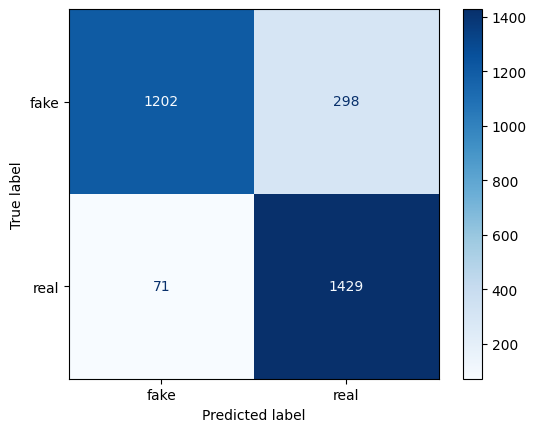

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Optional: display nicely
disp = ConfusionMatrixDisplay(cm, display_labels=val_ds.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()
